## Import modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import csv
import time
import nibabel as nib

import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils
from tensorflow.keras import optimizers

from tqdm.notebook import trange
import gc

In [3]:
print(tf.config.list_physical_devices('GPU'))

tpu_address = None
if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime')
else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print(tpu_address)


[]
grpc://10.19.203.242:8470


In [4]:
## hyper parameters
BATCH_SIZE = 32
EPOCHS = 20

&emsp;

## Load data

#### Load csv data

Some features has title, but no value in arbitrary data <br>
These data aren't showed in the below <br><br>
csv_data = [
<br>&emsp;&emsp;    [0]:&emsp;&nbsp;&nbsp; Image Data ID,
<br>&emsp;&emsp;    [1]:&emsp;&nbsp;&nbsp; Subject,
<br>&emsp;&emsp;    [2]:&emsp;&nbsp;&nbsp; Group,
<br>&emsp;&emsp;    [3]:&emsp;&nbsp;&nbsp; Sex,
<br>&emsp;&emsp;    [4]:&emsp;&nbsp;&nbsp; Age,
<br>&emsp;&emsp;    [5]:&emsp;&nbsp;&nbsp; Visit,
<br>&emsp;&emsp;    [6]:&emsp;&nbsp;&nbsp; Modality,
<br>&emsp;&emsp;    [7]:&emsp;&nbsp;&nbsp; Description,
<br>&emsp;&emsp;    [8]:&emsp;&nbsp;&nbsp; Type,
<br>&emsp;&emsp;    [9]:&emsp;&nbsp;&nbsp; Acq Date,
<br>&emsp;&emsp;    [10]:&emsp; Phase,
<br>&emsp;&emsp;    [11]:&emsp; Site ID,
<br>&emsp;&emsp;    [18]:&emsp; DXchange,
<br>]

<details style='color:red;'><summary>other features</summary>
    <br>&emsp;&emsp;    [12]:&emsp; VisCode,
    <br>&emsp;&emsp;    [13]:&emsp; VisCode2,
    <br>&emsp;&emsp;    [14]:&emsp; VisDate,
    <br>&emsp;&emsp;    [15]:&emsp; UserDate,
    <br>&emsp;&emsp;    [16]:&emsp; UserDate2,
    <br>&emsp;&emsp;    [17]:&emsp; ExamDate,
    <br>&emsp;&emsp;    [26]:&emsp; DXMDES,
    <br>&emsp;&emsp;    [27]:&emsp; DXMPTR1,
    <br>&emsp;&emsp;    [28]:&emsp; DXMPTR2,
    <br>&emsp;&emsp;    [29]:&emsp; DXMPTR3,
    <br>&emsp;&emsp;    [30]:&emsp; DXMPTR4,
    <br>&emsp;&emsp;    [31]:&emsp; DXMPTR5,
    <br>&emsp;&emsp;    [32]:&emsp; DXMPTR6,
    <br>&emsp;&emsp;    [33]:&emsp; DXMDUE,
    <br>&emsp;&emsp;    [34]:&emsp; DXMOTHET,
    <br>&emsp;&emsp;    [41]:&emsp; DXAPOSS,
    <br>&emsp;&emsp;    [42]:&emsp; DXPARK,
    <br>&emsp;&emsp;    [46]:&emsp; DXDEP,
    <br>&emsp;&emsp;    [51]:&emsp; update_stamp
</details>

In [5]:
csv_file_path = '/content/drive/MyDrive/data_B/dataB_change.csv'
dataset_idx = [0, 2, 18]
feature_idx = [4, 27, 28, 29, 30, 31, 32, 33, 46]

csv_data = []
features = []

invalid_ID = ['I306344', 'I425259', 'I319979', 'I321488', 'I376845', 'I335055']
with open(csv_file_path, encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file)

    # Skip the first row (header)
    next(csv_reader)
    for row in csv_reader:
        if row[0] in invalid_ID: continue
        # if row[7] != 'MPRAGE': continue
        if 'MPRAGE' not in row[7]: continue
        csv_data.append([row[i] for i in dataset_idx])
        features.append([int(row[i]) if row[i] != '' else 0 for i in feature_idx])

    del csv_reader
del invalid_ID

detail_MCI = ['EMCI', 'LMCI']
for i, data in enumerate(csv_data):
    if data[1] in detail_MCI:
        csv_data[i][1] = 'MCI'


csv_data_num = len(csv_data)
feature_num = len(feature_idx)
print(f'csv_data_num: {csv_data_num}')
print(f'feature_num: {feature_num}')

print(f'\ncsv_data: ')
for i, data in enumerate(csv_data):
    if i == 5: break
    print(data)

print(f'\nfeatures: ')
for i, data in enumerate(features):
    if i == 5: break
    print(data)

csv_data_num: 663
feature_num: 9

csv_data: 
['I228833', 'CN', '1']
['I228842', 'CN', '1']
['I234626', 'MCI', '5']
['I234627', 'MCI', '5']
['I238627', 'CN', '1']

features: 
[76, 0, 0, 0, 0, 0, 0, 0, 0]
[76, 0, 0, 0, 0, 0, 0, 0, 0]
[73, 0, 0, 0, 0, 0, 0, 0, 0]
[73, 0, 0, 0, 0, 0, 0, 0, 0]
[90, 0, 0, 0, 0, 0, 0, 0, 0]


#### Load nii data by iterator way

In [6]:
# def data_loader():
#     nii_data_path = '/content/drive/Shareddrives/ML Group 27/ADNI/dataB/'
#     global features, csv_data, BATCH_SIZE

#     while True:
#         idx = np.random.permutation(len(csv_data))

#         for start in range(0, len(idx), BATCH_SIZE):
#             batch_idx = idx[start : start + BATCH_SIZE]
#             batch_data = [nib.load(nii_data_path + f'{csv_data[i][0]}.nii').get_fdata() for i in batch_idx]
#             batch_feature = [features[i] for i in batch_idx]
#             yield np.array(batch_data)

# loader = data_loader()
# data = next(loader)
# print(len(data))
# for i in range(5):
#     print(len(data[i]))
fdata_path = '/content/drive/MyDrive/data_B/nii_fdata.npy'
if os.path.isfile(fdata_path):
    mri_data = np.load(fdata_path)
    mri_data = np.reshape(mri_data,  (csv_data_num, 96, 96, 96))
else:
    nii_data_path = '/content/drive/Shareddrives/ML Group 27/ADNI/dataB/'
    mri_data = np.array([])
    for i in trange(csv_data_num):
        mri_data = np.append(mri_data, np.resize(nib.load(nii_data_path + f'{csv_data[i][0]}.nii').get_fdata(), (96, 96, 96)))
    mri_data = np.reshape(mri_data, (csv_data_num, 96, 96, 96))
    np.save(fdata_path, mri_data)
    # gc.collect()
    # mri_data.append(np.resize(np.array(nii_data), (96, 96, 96)))
    # mri_data.append(np.array(nii_data).resize(96, 96, 96))

In [7]:
print(mri_data.shape)
print(mri_data[0])

(663, 96, 96, 96)
[[[21. 27.  0. ...  9.  5.  8.]
  [ 7.  7.  0. ...  3.  3.  2.]
  [ 2.  5.  1. ... 63.  1. 20.]
  ...
  [ 1.  6.  5. ... 14.  3.  7.]
  [ 6.  5. 10. ...  4. 12.  0.]
  [ 4. 10.  3. ...  4.  5.  0.]]

 [[24. 16. 27. ... 14. 10.  4.]
  [15. 10.  4. ...  7.  6.  6.]
  [ 3.  7.  3. ... 11.  5.  8.]
  ...
  [ 1.  9.  2. ...  5. 15. 11.]
  [20.  5.  9. ...  8.  2.  1.]
  [ 4.  2.  8. ...  4.  3.  0.]]

 [[24. 49. 33. ...  5. 13.  5.]
  [ 3. 15.  6. ...  5.  8.  6.]
  [ 5.  6.  7. ... 21.  7. 10.]
  ...
  [ 4.  0.  4. ... 16.  6. 11.]
  [ 7. 10.  9. ...  8.  2.  6.]
  [ 6. 10. 12. ...  2.  4.  0.]]

 ...

 [[ 8.  5.  6. ... 12.  3. 10.]
  [ 8.  3.  5. ...  7.  9.  2.]
  [ 2.  0.  5. ...  8. 11.  5.]
  ...
  [ 3.  3.  3. ...  7. 12.  3.]
  [ 9. 18.  3. ... 11.  0.  5.]
  [11.  8.  3. ...  5.  5.  0.]]

 [[38. 43. 50. ...  6.  6. 17.]
  [16.  6.  5. ...  1.  7.  8.]
  [ 8.  5.  1. ...  8. 23.  4.]
  ...
  [ 1. 12.  8. ... 13. 12.  9.]
  [ 6. 14.  1. ... 10.  4.  7.]
  [14. 12.

&emsp;

## Check and partition the data

#### Check if there is any repeated ID in data set

In [8]:
Image_ID_set = set()
for data in csv_data:
    Image_ID_set.add(data[0])

if len(Image_ID_set) != len(csv_data):
    print("There are some ID repeated in csv_data and nii_data")
    print(f'Image_ID_set: {len(Image_ID_set)}')
    print(f'nii_data: {len(csv_data)}')
else:
    print("All ID are unique")
    print(f'Image_ID_set: {len(Image_ID_set)}')
    print(f'nii_data: {len(csv_data)}')


All ID are unique
Image_ID_set: 663
nii_data: 663


#### Draw the Groups distribution of data set

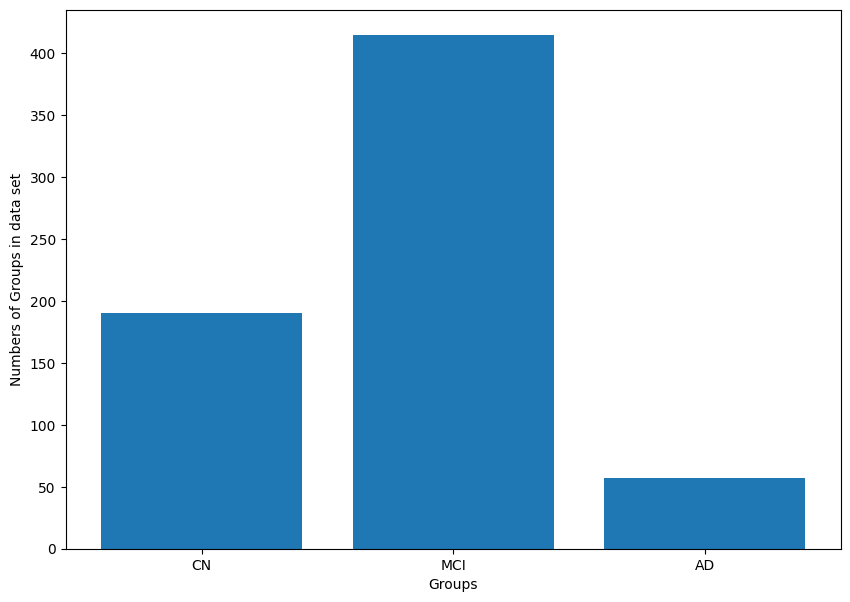

In [9]:
def Groups_distribution(data_set):
    GROUPS = ['CN', 'MCI', 'AD']

    distribution_groups = [len(['_' for data in data_set if data[1] == i]) for i in GROUPS]
    plt.figure(figsize = (10, 7))
    plt.bar(GROUPS, distribution_groups)
    plt.xlabel('Groups')
    plt.ylabel('Numbers of Groups in data set')

    plt.show()

Groups_distribution(csv_data)

#### Draw the DX change distribution of data set

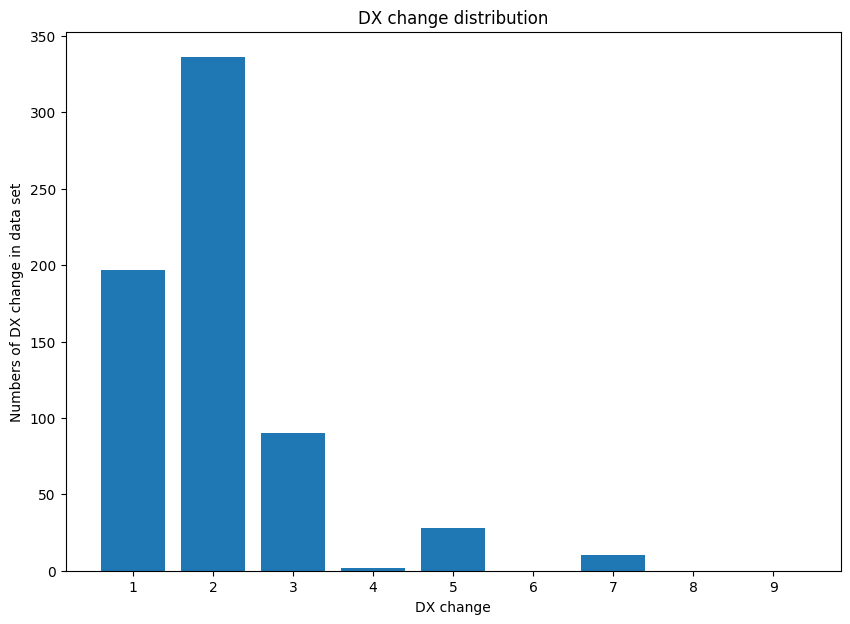

[197, 336, 90, 2, 28, 0, 10, 0, 0]


In [10]:
def DXchange_distribution(data_set):
    DXCHANGES = [f'{i}' for i in range(1, 10)]

    distribution_dxchange = [len(['_' for data in data_set if data[2] == i]) for i in DXCHANGES]

    plt.figure(figsize = (10, 7))
    plt.bar(DXCHANGES, distribution_dxchange)
    plt.xlabel('DX change')
    plt.ylabel('Numbers of DX change in data set')
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(50))
    plt.title('DX change distribution')
    plt.show()

    print(distribution_dxchange)

DXchange_distribution(csv_data)

#### Partition the data set into train_set, validation_set and test_set

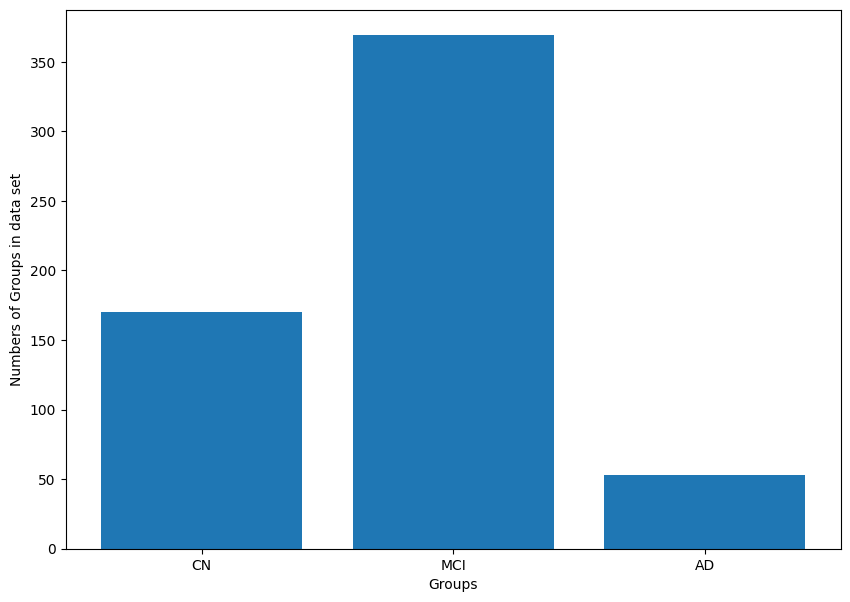

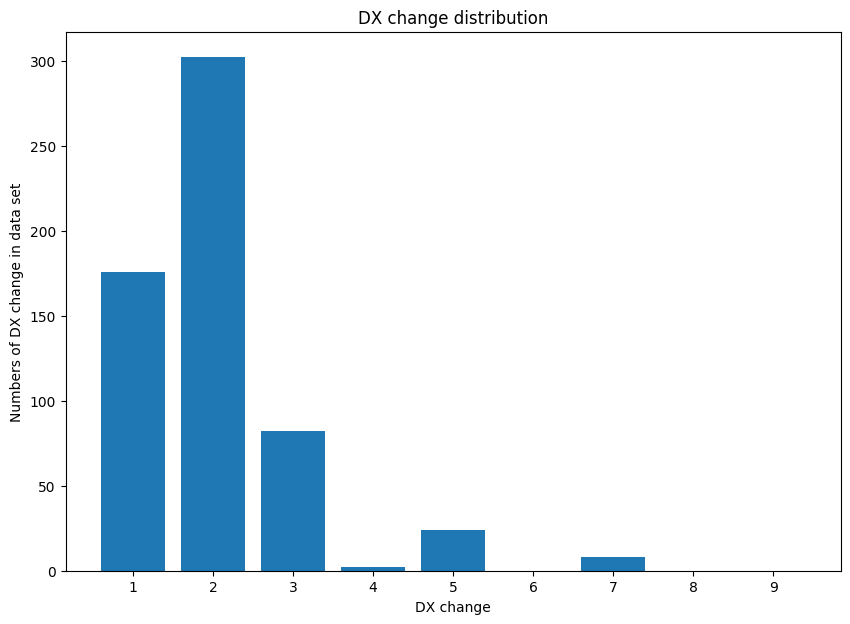

[176, 302, 82, 2, 24, 0, 8, 0, 0]



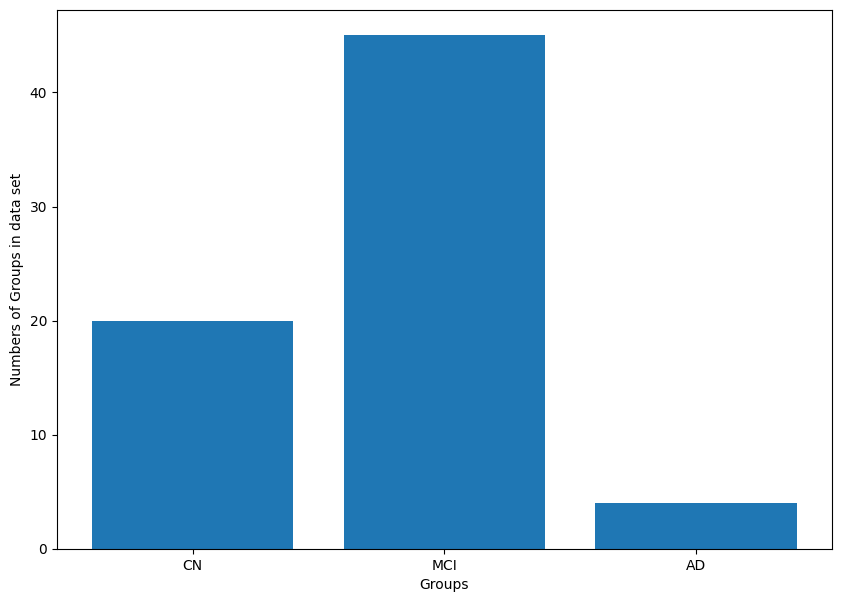

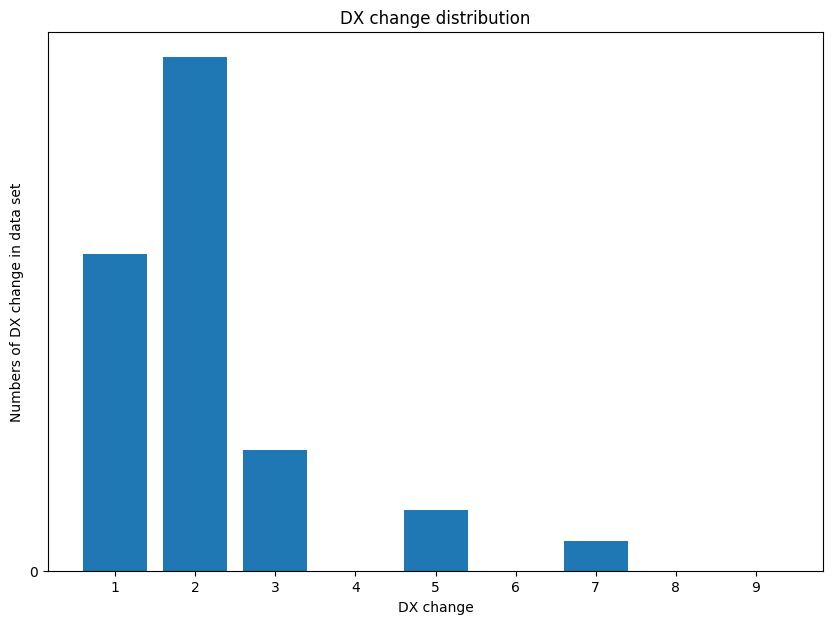

[21, 34, 8, 0, 4, 0, 2, 0, 0]


In [11]:
seed = 'ML final project q2ropijf'
random.seed(sum(seed.encode('ascii')))
random.shuffle(csv_data)

boundary_1 = len(csv_data) // 10 * 8
boundary_2 = len(csv_data) // 10 * 9

train_set = csv_data[0 : boundary_2]
# validation_set = csv_data[boundary_1 : boundary_2]
test_set = csv_data[boundary_2 : ]

Groups_distribution(train_set)
DXchange_distribution(train_set)
print()

# Groups_distribution(validation_set)
# DXchange_distribution(validation_set)
# print()

Groups_distribution(test_set)
DXchange_distribution(test_set)

In [12]:
train_label = [int(data[2]) for data in train_set]
train_label = utils.to_categorical(train_label, num_classes = 9)
train_mri = np.array(mri_data[0 : boundary_2])
train_feature = np.array(features[0 : boundary_2])

# validation_label = [int(data[2]) for data in validation_set]
# validation_label = utils.to_categorical(validation_label, num_classes = 9)
# validation_mri = np.array(mri_data[boundary_1 : boundary_2])
# validation_feature = np.array(features[boundary_1 : boundary_2])

test_label = [int(data[2]) for data in test_set]
test_label = utils.to_categorical(test_label, num_classes = 9)
test_mri = np.array(mri_data[boundary_2 : ])
test_feature = np.array(features[boundary_2 : ])

# print(type(train_mri), type(train_mri[0]), type(train_mri[0][0]))s

&emsp;

## Train the model

In [13]:
if tpu_address != None:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

In [14]:
def model():
    def CNN_model():
        model = models.Sequential()
        model.add(layers.Conv3D(48, (3, 3, 3), input_shape = (96, 96, 96, 1)))
        model.add(layers.Normalization())
        # model.add(layers.Conv3D(48, (3, 3, 3)))
        model.add(layers.Activation('leaky_relu'))
        model.add(layers.MaxPooling3D((2, 2, 2)))
        # model.add(layers.Dropout(0.2))

        # model.add(layers.Conv3D(96, (3, 3, 3)))
        # model.add(layers.Conv3D(48, (3, 3, 3)))
        # model.add(layers.Normalization())
        # model.add(layers.Activation('leaky_relu'))
        # model.add(layers.MaxPooling3D((2, 2, 2)))
        # model.add(layers.Dropout(0.1))

        model.add(layers.Flatten())
        model.add(layers.Dense(24, activation = 'leaky_relu'))
        model.add(layers.Dense(9, activation = 'softmax'))
        return model

    def feature_model():
        model = models.Sequential()
        model.add(layers.Dense(0.5 * feature_num, activation = 'leaky_relu', input_shape = (feature_num,)))
        # model.add(layers.Dropout(0.1))
        # model.add(layers.Dense(feature_num, activation = 'sigmoid'))
        # model.add(layers.Dropout(0.1))
        model.add(layers.Dense(9, activation = 'softmax'))
        return model

    cnn_model = CNN_model()
    feature_model = feature_model()
    merged = layers.concatenate([cnn_model.output, feature_model.output])

    merged = layers.Dropout(0.1)(merged)
    merged = layers.Dense(18, activation = 'leaky_relu')(merged)
    merged = layers.Dense(32, activation = 'sigmoid')(merged)
    # merged = layers.Dropout(0.1)(merged)
    merged = layers.Dense(9, activation = 'softmax')(merged)

    model = models.Model(inputs = [cnn_model.input, feature_model.input], outputs = merged)
    return model

# normalization_layer = layers.Normalization()
# normalization_layer.adapt(train_mri)

run_in_tpu = True
if tpu_address != None and run_in_tpu:
    with strategy.scope():
        model2 = model()
        optimizers.experimental.Adam(
            learning_rate = 0.01,
        )
        model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        print('tpu train')
else:
    model = model()
    optimizers.experimental.Adam(
        learning_rate = 0.01,
    )
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print('cpu train')

model2.summary()

tpu train
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv3d_input (InputLayer)      [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 94, 94, 94,   1344        ['conv3d_input[0][0]']           
                                48)                                                               
                                                                                                  
 normalization (Normalization)  (None, 94, 94, 94,   97          ['conv3d[0][0]']                 
                                48)                                                 

In [15]:
tf.config.experimental_run_functions_eagerly(False)
history = model2.fit(
    x = [train_mri, train_feature],
    y = train_label,
    epochs = EPOCHS - 5,
    shuffle = True,
    # validation_data = ([validation_mri, validation_feature], validation_label),
    validation_split = 0.1
)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Epoch 1/15
17/17 [==============================] - 45s 2s/step - loss: 1.8153 - accuracy: 0.2322 - val_loss: 1.6741 - val_accuracy: 0.5000
Epoch 2/15
17/17 [==============================] - 4s 236ms/step - loss: 1.5479 - accuracy: 0.5150 - val_loss: 1.4921 - val_accuracy: 0.5000
Epoch 3/15
17/17 [==============================] - 4s 254ms/step - loss: 1.3945 - accuracy: 0.5094 - val_loss: 1.3914 - val_accuracy: 0.5000
Epoch 4/15
17/17 [==============================] - 4s 254ms/step - loss: 1.3191 - accuracy: 0.5094 - val_loss: 1.3427 - val_accuracy: 0.5000
Epoch 5/15
17/17 [==============================] - 4s 248ms/step - loss: 1.2709 - accuracy: 0.5094 - val_loss: 1.3059 - val_accuracy: 0.5000
Epoch 6/15
17/17 [==============================] - 4s 238ms/step - loss: 1.2480 - accuracy: 0.5094 - val_loss: 1.2821 - val_accuracy: 0.5000
Epoch 7/15
17/17 [==============================] - 4s 233ms/step - loss: 1.2369 - accuracy: 0.5094 - val_loss: 1.2611 - val_accuracy: 0.5000
Epoch 8/

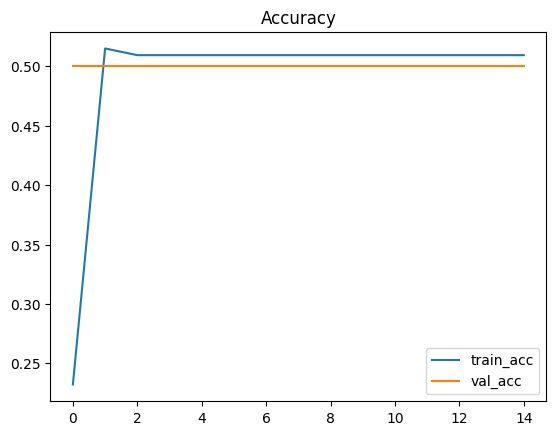

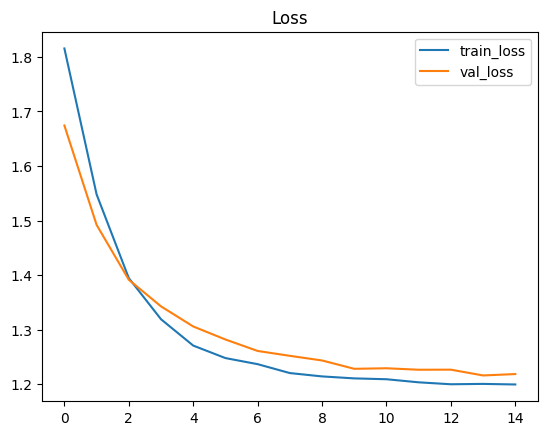

In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, label = 'train_acc')
plt.plot(val_acc, label = 'val_acc')
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(train_loss, label = 'train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.title("Loss")
plt.legend()
plt.show()

In [17]:
test_loss, test_acc = model2.evaluate([test_mri, test_feature], test_label)
print(f"Test Accuracy: {test_acc}")

3/3 [==============================] - 10s 5s/step - loss: 1.2530 - accuracy: 0.4928
Test Accuracy: 0.49275362491607666
